# Smooth stitching

El algoritmo toma un directrio de chips binarios (resultado de una predicción), y que están *solapados*, y genera un nuevo directorio de chips *no solapados*, pero fusionados de manera suave. La manera en la que fusiona los chips solapados es con una ventana

In [7]:
import logging
import math
import os
import tempfile
from glob import glob

import numpy as np
import scipy.signal
import rasterio
import rasterio.merge
import rasterio.windows
import rasterio.mask
import matplotlib.pyplot as plt
import cv2
from rasterio.windows import Window
from rasterio.transform import Affine
from rtree import index
from shapely.geometry import box

from tqdm import tqdm
# from tqdm.notebook import tqdm

In [4]:
logger = logging.getLogger(__name__)

## Spline interpolation

In [194]:
def spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind

def window_2D(window_size, power=2, n_channels=1):
    """
    Make a 1D window function, then infer and return a 2D window function.
    """
    wind = spline_window(window_size, power)
    wind = np.expand_dims(wind, 0)
    wind = (wind * wind.transpose()) / 4
    return np.repeat(wind, n_channels).reshape(window_size, window_size, n_channels)

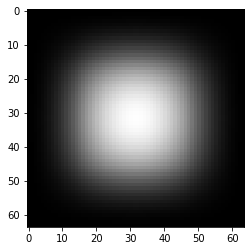

In [193]:
plt.imshow(window_2D(64, power=2, n_channels=3))

In [6]:
def get_dummy_img(xy_size=128, nb_channels=3):
    """
    Create a random image with different luminosity in the corners.
    Returns an array of shape (xy_size, xy_size, nb_channels).
    """
    x = np.random.random((xy_size, xy_size, nb_channels))
    x = x + np.ones((xy_size, xy_size, 1))
    lin = np.expand_dims(np.linspace(0, 1, xy_size), 0)
    lin_2d = lin * lin.transpose()
    lin_nd = np.repeat(lin_2d, nb_channels).reshape(xy_size, xy_size, nb_channels)
    x = x * lin_nd
    x = x + x[::-1, ::-1, :]
    x = x - np.min(x)
    x = x / np.max(x) / 2
    return x

(160, 160, 1)


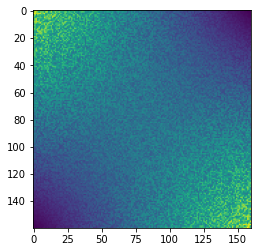

In [7]:
img = get_dummy_img(160, 1)
print(img.shape)
plt.imshow(img[:,:,0])

## Merge overlapping chips

In [144]:
def merge(images_files, power=2, *, win_box, shape, dtype):
    parts = []
    blended_parts = []
    spline_2d = _window_2D(shape[0], power=power, n_channels=shape[2])
    img = np.zeros(shape, dtype=dtype)
    for img_path in images_files:
        with rasterio.open(img_path) as src:
            mask_bbox = win_box.intersection(box(*src.bounds))
            out_img, _ = rasterio.mask.mask(src, [mask_bbox])
        out_img = np.dstack(out_img)
        parts.append(out_img)
        out_img = out_img * spline_2d
        blended_parts.append(out_img)
        img = np.mean([img, out_img], axis=0)
    return img, parts, blended_parts

In [145]:
base_dir = os.path.join(os.path.expanduser('~'), 'dym/satlomas-back/data/lomas_changes/s2/predict/20201001_20201101')

test_images = ['tci_44_21.tif', 'tci_44_22.tif', 'tci_44_23.tif']
test_images = [os.path.join(base_dir, p) for p in test_images]
test_images

['/home/munshkr/dym/satlomas-back/data/lomas_changes/s2/predict/20201001_20201101/tci_44_21.tif',
 '/home/munshkr/dym/satlomas-back/data/lomas_changes/s2/predict/20201001_20201101/tci_44_22.tif',
 '/home/munshkr/dym/satlomas-back/data/lomas_changes/s2/predict/20201001_20201101/tci_44_23.tif']

In [146]:
ref_img_path = test_images[1]
print(ref_img_path)
with rasterio.open(ref_img_path) as src:
    chip_bbox = box(*src.bounds)
    chip_size = src.width
    assert(src.width == src.height)
    chip_band_count = src.count
    chip_dtype = src.profile['dtype']

/home/munshkr/dym/satlomas-back/data/lomas_changes/s2/predict/20201001_20201101/tci_44_22.tif


(1, 32, 64)


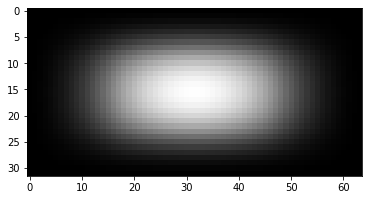

In [255]:
plt.imshow(np.dstack(window_2D(height=32, width=64, n_channels=3)))

In [258]:
def window_2D(power=2, n_channels=1, *, height, width):
    max_size = max(height, width)
    wind = spline_window(max_size, power)
    wind = np.expand_dims(wind, 0)
    wind = (wind * wind.transpose()) / 4
    wind = np.expand_dims(cv2.resize(wind, (width, height)), axis=0)
    return np.repeat(wind, n_channels, axis=0).reshape(n_channels, height, width)

# Taken from 'max' method on https://github.com/mapbox/rasterio/blob/master/rasterio/merge.py
def mean_merge_method(old_data, new_data, old_nodata, new_nodata, index=None, roff=None, coff=None):
    n_channels, height, width = old_data.shape
    spline_2d = window_2D(height=height, width=width, power=2, n_channels=n_channels)
    new_data = new_data * spline_2d
        
    mask = np.logical_and(~old_nodata, ~new_nodata)
    old_data[mask] = np.mean([old_data[mask], new_data[mask]], axis=0)

    mask = np.logical_and(old_nodata, ~new_nodata)
    old_data[mask] = new_data[mask]

In [259]:
with rasterio.open(ref_img_path) as src:
    ref_bounds = src.bounds
datasets = [rasterio.open(p) for p in test_images]
merged_img, merged_t = rasterio.merge.merge(datasets, bounds=ref_bounds, method=mean_merge_method)
for ds in datasets:
    ds.close()

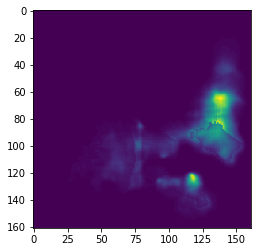

In [260]:
plt.imshow(merged_img[0,:,:])

## Final

In [279]:
def spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind

def window_2D(power=2, n_channels=1, *, height, width):
    if height == 0 or width == 0:
        return np.zeros((n_channels, height, width))
    max_size = max(height, width)
    wind = spline_window(max_size, power)
    wind = np.expand_dims(wind, 0)
    wind = (wind * wind.transpose()) / 4
    wind = cv2.resize(wind, (width, height))
    wind = np.expand_dims(wind, axis=0)
    return np.repeat(wind, n_channels, axis=0).reshape(n_channels, height, width)

# Taken from 'max' method on https://github.com/mapbox/rasterio/blob/master/rasterio/merge.py
def mean_merge_method(old_data, new_data, old_nodata, new_nodata, index=None, roff=None, coff=None):
    n_channels, height, width = old_data.shape
    spline_2d = window_2D(height=height, width=width, power=2, n_channels=n_channels)
    new_data = new_data * spline_2d
        
    mask = np.logical_and(~old_nodata, ~new_nodata)
    old_data[mask] = np.mean([old_data[mask], new_data[mask]], axis=0)

    mask = np.logical_and(old_nodata, ~new_nodata)
    old_data[mask] = new_data[mask]

def build_bounds_index(image_files):
    """Returns bounds of merged images and builds an R-Tree index"""
    idx = index.Index()
    xs = []
    ys = []
    for i, img_path in tqdm(list(enumerate(image_files))):
        with rasterio.open(img_path) as src:
            left, bottom, right, top = src.bounds
        xs.extend([left, right])
        ys.extend([bottom, top])
        idx.insert(i, (left, bottom, right, top))
    dst_w, dst_s, dst_e, dst_n = min(xs), min(ys), max(xs), max(ys)
    return idx, (dst_w, dst_s, dst_e, dst_n)

def sliding_windows(size, whole=False, step_size=None, *, width, height):
    """Slide a window of +size+ by moving it +step_size+ pixels"""
    if not step_size:
        step_size = size
    w, h = (size, size)
    sw, sh = (step_size, step_size)
    end_i = height - h if whole else height
    end_j = width - w if whole else width
    for pos_i, i in enumerate(range(0, end_i, sh)):
        for pos_j, j in enumerate(range(0, end_j, sw)):
            real_w = w if whole else min(w, abs(width - j))
            real_h = h if whole else min(h, abs(height - i))
            yield rasterio.windows.Window(j, i, real_w, real_h), (pos_i, pos_j)
            
def merge_chips(images_files, *, win_bounds):
    datasets = [rasterio.open(p) for p in images_files]
    img, _ = rasterio.merge.merge(datasets, bounds=win_bounds, method=mean_merge_method)
    for ds in datasets:
        ds.close()
    return img

def smooth_stitch(*, input_dir, output_dir):
    image_paths = glob(os.path.join(input_dir, '*.tif'))
    if not image_paths:
        raise RuntimeError("%s does not contain any .tif file" % (input_dir))

    # Get the profile and affine of some image as template for output image
    first_image = image_paths[0]
    with rasterio.open(first_image) as src:
        profile = src.profile.copy()
        src_res = src.res
        src_count = src.count
        chip_size = src.width
        assert(src.width == src.height)
        # nodataval = src.nodatavals[0]
        # dt = src.dtypes[0]
        # transform = src.transform

    # Get bounds from all images and build R-Tree index
    idx, (dst_w, dst_s, dst_e, dst_n) = build_bounds_index(image_paths)

    # Get affine transform for complete bounds
    logger.info("Output bounds: %r", (dst_w, dst_s, dst_e, dst_n))
    output_transform = Affine.translation(dst_w, dst_n)
    logger.info("Output transform, before scaling: %r", output_transform)

    output_transform *= Affine.scale(src_res[0], -src_res[1])
    logger.info("Output transform, after scaling: %r", output_transform)

    # Compute output array shape. We guarantee it will cover the output
    # bounds completely. We need this to build windows list later.
    output_width = int(math.ceil((dst_e - dst_w) / src_res[0]))
    output_height = int(math.ceil((dst_n - dst_s) / src_res[1]))

    # Adjust bounds to fit
    #dst_e, dst_s = output_transform * (output_width, output_height)
    #logger.info("Output width: %d, height: %d", output_width, output_height)
    #logger.info("Adjusted bounds: %r", (dst_w, dst_s, dst_e, dst_n))

    # Set width and height for output chips, and other attributes
    profile.update(width=chip_size,
                   height=chip_size,
                   #count=1,  # TODO REMOVE
                   tiled=True)
    shape = (chip_size, chip_size, profile['count'])
    
    windows = list(sliding_windows(chip_size,
                                   width=output_width,
                                   height=output_height))
    logger.info("Num. windows:", len(windows))

    for win, (i, j) in tqdm(windows):
        # Get window affine transform and bounds
        win_transform = rasterio.windows.transform(win, output_transform)
        win_bounds = rasterio.windows.bounds(win, output_transform)
        
        # Get chips that intersect with window
        intersect_chip_paths = [image_paths[i] for i in idx.intersection(win_bounds)]
        
        if intersect_chip_paths:
            # Merge them by applying spline window
            img = merge_chips(intersect_chip_paths, win_bounds=win_bounds)

            # Write output chip
            profile.update(transform=win_transform)
            output_path = os.path.join(output_dir, f'{i}_{j}.tif')

            os.makedirs(output_dir, exist_ok=True)
            with rasterio.open(output_path, 'w', **profile) as dst:
                #img = (get_dummy_img(chip_size, 1)[:,:,0] * 2 * 255).astype(np.uint8)
                for i in range(img.shape[0]):
                    dst.write(img[i, :, :], i + 1)

In [280]:
input_dir = os.path.join(os.path.expanduser('~'), 'dym/satlomas-back/data/lomas_changes/s2/predict/20201001_20201101')
output_dir = '/tmp/stitch/'

smooth_stitch(input_dir=input_dir, output_dir=output_dir)

100%|██████████| 2457/2457 [00:57<00:00, 43.01it/s] 


## Segundo intento

Después de consultarlo con la almohada entendí que estaba mal con el algoritmo. Debería hacer lo siguiente:
- En un directorio temoporal, para cada chip, multiplicarlo por una ventana de spline de ese tamaño
- Mergear con mediana (usando `rasterio.merge.merge`)

In [29]:
def spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind

def window_2D(power=2, n_channels=1, *, height, width):
    if height == 0 or width == 0:
        return np.zeros((n_channels, height, width))
    max_size = max(height, width)
    wind = spline_window(max_size, power)
    wind = np.expand_dims(wind, 0)
    wind = (wind * wind.transpose()) / 4
    wind = cv2.resize(wind, (width, height))
    wind = np.expand_dims(wind, axis=0)
    return np.repeat(wind, n_channels, axis=0).reshape(n_channels, height, width)

def generate_spline_window_chips(*, image_paths, output_dir):
    if not image_paths:
        return []
    
    first_image = image_paths[0]
    with rasterio.open(first_image) as src:
        chip_size = src.width
        n_channels = src.count
        assert(src.width == src.height)
    
    spline_window = window_2D(height=chip_size, width=chip_size, power=2, n_channels=n_channels)
    
    res = []
    for img_path in tqdm(image_paths):
        with rasterio.open(img_path) as src:
            profile = src.profile.copy()
            img = src.read()
            
        img = (img * spline_window).astype(np.uint8)

        out_path = os.path.join(output_dir, os.path.basename(img_path))
        os.makedirs(output_dir, exist_ok=True)
        res.append(out_path)
        with rasterio.open(out_path, 'w', **profile) as dst:
            for i in range(img.shape[0]):
                dst.write(img[i, :, :], i + 1)
    
    return res
                
# Taken from 'max' method on https://github.com/mapbox/rasterio/blob/master/rasterio/merge.py
def mean_merge_method(old_data, new_data, old_nodata, new_nodata, index=None, roff=None, coff=None):
    n_channels, height, width = old_data.shape
        
    mask = np.logical_and(~old_nodata, ~new_nodata)
    old_data[mask] = np.median([old_data[mask], new_data[mask]], axis=0)

    mask = np.logical_and(old_nodata, ~new_nodata)
    old_data[mask] = new_data[mask]
    
def build_bounds_index(image_files):
    """Returns bounds of merged images and builds an R-Tree index"""
    idx = index.Index()
    xs = []
    ys = []
    for i, img_path in tqdm(list(enumerate(image_files))):
        with rasterio.open(img_path) as src:
            left, bottom, right, top = src.bounds
        xs.extend([left, right])
        ys.extend([bottom, top])
        idx.insert(i, (left, bottom, right, top))
    dst_w, dst_s, dst_e, dst_n = min(xs), min(ys), max(xs), max(ys)
    return idx, (dst_w, dst_s, dst_e, dst_n)

def sliding_windows(size, whole=False, step_size=None, *, width, height):
    """Slide a window of +size+ by moving it +step_size+ pixels"""
    if not step_size:
        step_size = size
    w, h = (size, size)
    sw, sh = (step_size, step_size)
    end_i = height - h if whole else height
    end_j = width - w if whole else width
    for pos_i, i in enumerate(range(0, end_i, sh)):
        for pos_j, j in enumerate(range(0, end_j, sw)):
            real_w = w if whole else min(w, abs(width - j))
            real_h = h if whole else min(h, abs(height - i))
            yield rasterio.windows.Window(j, i, real_w, real_h), (pos_i, pos_j)    
                
def merge_chips(images_files, *, win_bounds):
    datasets = [rasterio.open(p) for p in images_files]
    img, _ = rasterio.merge.merge(datasets, bounds=win_bounds, method=mean_merge_method)
    for ds in datasets:
        ds.close()
    return img
                
def smooth_stitch(*, input_dir, output_dir):
    image_paths = glob(os.path.join(input_dir, '*.tif'))
    if not image_paths:
        raise RuntimeError("%s does not contain any .tif file" % (input_dir))

    # Get the profile and affine of some image as template for output image
    first_image = image_paths[0]
    with rasterio.open(first_image) as src:
        profile = src.profile.copy()
        src_res = src.res
        src_count = src.count
        chip_size = src.width
        assert(src.width == src.height)
        
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_image_paths = generate_spline_window_chips(image_paths=image_paths, output_dir=tmpdir)

        # Get bounds from all images and build R-Tree index
        idx, (dst_w, dst_s, dst_e, dst_n) = build_bounds_index(tmp_image_paths)

        # Get affine transform for complete bounds
        logger.info("Output bounds: %r", (dst_w, dst_s, dst_e, dst_n))
        output_transform = Affine.translation(dst_w, dst_n)
        logger.info("Output transform, before scaling: %r", output_transform)

        output_transform *= Affine.scale(src_res[0], -src_res[1])
        logger.info("Output transform, after scaling: %r", output_transform)

        # Compute output array shape. We guarantee it will cover the output
        # bounds completely. We need this to build windows list later.
        output_width = int(math.ceil((dst_e - dst_w) / src_res[0]))
        output_height = int(math.ceil((dst_n - dst_s) / src_res[1]))

        # Set width and height for output chips, and other attributes
        profile.update(width=chip_size,
                       height=chip_size,
                       tiled=True)
        shape = (chip_size, chip_size, profile['count'])

        windows = list(sliding_windows(chip_size,
                                       width=output_width,
                                       height=output_height))
        logger.info("Num. windows:", len(windows))

        for win, (i, j) in tqdm(windows):
            # Get window affine transform and bounds
            win_transform = rasterio.windows.transform(win, output_transform)
            win_bounds = rasterio.windows.bounds(win, output_transform)

            # Get chips that intersect with window
            intersect_chip_paths = [tmp_image_paths[i] for i in idx.intersection(win_bounds)]

            if intersect_chip_paths:
                # Merge them by applying spline window
                img = merge_chips(intersect_chip_paths, win_bounds=win_bounds)

                # Write output chip
                profile.update(transform=win_transform)
                output_path = os.path.join(output_dir, f'{i}_{j}.tif')

                os.makedirs(output_dir, exist_ok=True)
                with rasterio.open(output_path, 'w', **profile) as dst:
                    for i in range(img.shape[0]):
                        dst.write(img[i, :, :], i + 1)

In [30]:
input_dir = os.path.join(os.path.expanduser('~'), 'dym/satlomas-back/data/lomas_changes/s2/predict/20201001_20201101')
output_dir = '/tmp/stitch3/'

smooth_stitch(input_dir=input_dir, output_dir=output_dir)

100%|██████████| 2457/2457 [00:50<00:00, 48.63it/s] 
